# Table of contents
1. [Motivation](#Motivation)
2. [Basic](#Basic)
    1. [Extracting Data from wikipedia](#Extracting)
    2. [Gather each scientists wikipage](#Get_wiki)
    3. [Parsing the data for constructing the network](#network)
    4. [Parsing the data for text analysis](#text_analyses)
    5. [Presentation of final dataset](#presentation_dataset)
    6. [Conclusion on Basic Statistics](#conc_base)
3. [Tools, theory, and analysis](#analyse)
    1. [Communities](#communities)
    2. [TF-IDF](#TF_IDF)
    3. [HSBM](#HSBM)
4. [Discussion. Think critically about your creation](#discussion)
5. [Contributions](#contributions)

The main finding of the project are presented [on this website](https://esbenbl.github.io/site_host/)

# Motivation <a name="Motivation"></a>

In this project, we set out to explore the boundaries and intersections of the established social science disciplines. Is the traditional division of the social sciences into anthropology, political science, economy, sociology, and psychology a meaningful distinction of mutally exlusive and clearly defined fields of practice? Are the five categorizations merely historic relics that gradually have become more and more interwoven with one another? Or should even more granular disciplines be established? Perhaps it is time to revisit the classical demarcations and introduce new disciplines within the social sciences (based on the content of their field of interest, common inspirations and aversions, theoretical concepts, and methodological practices).

We examine the Wikipedia-page content of the most prominent social scientists within anthropology, political science, economy, sociology, and psychology. First, we connect the social scientists in a network based on whom they link to on their individual Wikipedia page. We examine who are the most connected **both within and across disciplines** as this might indicate who have had the most influence. Then, we deploy community detection to identify particularly connected groups within the network and compare these communities to the partition based on the established disciplines. Thus, we either deconstruct or reinforce the traditional boundaries between the social science disciplines. We move on to further examine what distinguishes the disciplines, by analyzing the textual content of the Wikipedia-pages. We create a TF-IDF to identify and assess which words are the most defining both within disciplines and communities. Lastly, we use a hSBM to find prominent topics within the social sciences that are either delimited to exist within the disciplines or connecting social scientists across disciplines. We create a bipartite network of topics and social scientists to illustrate these dynamics, and conclude by proposing a softening of the traditional boundaries of the social sciences. 

Our dataset consists of 3090 files extracted from Wikipedia-pages of scientists from the social science disciplines: Anthropologists, political scientists, economists, sociologists, and psychologists. The files contain links connecting the scientists as well as text describing their scientific contributions. These properties of the data allow us to make the analysis described above, which we hope will give the reader a new and more nuanced perspective of the boundaries and intersections of the social sciences. 

## **SKRIV LIGE IGENNEM NÅR VI ER FÆRDIGE MED ANALYSE Å' SÅ'RN**

# Basic Statistics  <a name="Basic"></a>

<br></br>
To examine the boundaries and intersections within the social scientists, we found inspiration in the Faculty of Social Science at Copenhagen University. The Social Science faculty have five overall departments: Sociology, Psychology, Economy, Anthropology, and Political Science. For each of the five categories, we found <a href="https://esbenbl.github.io/site_host/docs/the_project/Dataset/Datasets/#the-wikipedia-lists" target="_blank">a list of prevalent scientists on Wikipedia</a>, and used these as entries in our dataset. We used the extracted list of social scientists to construct two datasets: <br><br>
- 1) An edge- and nodelist for constructing a network, where an edge is created if a scientist is mentioned on another scientist's Wikipedia-page. <br><br>

- 2) Text data from each of the scientists' Wikipedia-page, which will be used to calculate both the TF-IDF scores, as well as the hSBM model.<br><br>

In this section, we go over the process of attaining our data, and present basic statistics of our final dataset.

<br></br>
First, we go through [the extraction of data from Wikipedia](#Extracting), both the list of scientists, and the content on the individual scientists Wikipedia-page. Then, we [parse the Wikipedia network data](#network) to construct the node- and link list. Concluding the run down of our data cleaning process, we [parse and preprocess the text analysis data](#text_analyses) which will be used to calculate both the TF-IDF scores, as well as the hSBM model. 

<br></br>
In the [presentation of our dataset](#presentation_dataset), we [construct our network](#construct_network) and examine the [degree distribution](#deg_dist) as well as the [most connected nodes](#top_nodes).

##### TING DER MANGLER HER: 
- Lidt stats skal skrive ind rundt omkring. Særligt netværksdelen. 
- Jeg har ikke skrevet om hvornår vi går fra hele netværket og kun til kernen (jesus?). 

Krav:
- Write about your choices in data cleaning and preprocessing

- Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

### Extracting data from Wikipedia <a name="Extracting"></a>

Our data gathering process has two parts: 

- 1) [get social scientists from each of the five lists](#Get_list_wiki)
- 2) [gather content for each of the scientists' wikipage](#Get_sci_wiki)

#### Extract Social Scientists from  the Five Lists of Scientists <a name="Get_list_wiki"></a>

We write a function to call the Wikipedia API for each of the five lists of social scientists, utilizing that the url suffix is `List_of_{discipline}`.

In [4]:
####################################CALLING THE API for the five lists####################################################
import requests
import pandas as pd
from bs4 import BeautifulSoup
import regex as re 
import json

def get_wiki(_page, get_txt = False):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = f"titles={_page}"
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    print(query)
    
    if get_txt == True:
        resp = requests.get(query).json()
        page_id = [i for i in resp['query']['pages'].keys()][0] # get page id
        txt = resp['query']['pages'][page_id]['revisions'][0]['slots']['main']['*']
        return txt
    
    else:
        return requests.get(query).json()

resp_soc = get_wiki("List_of_sociologists")
resp_ant = get_wiki("List_of_anthropologists")
resp_pol = get_wiki("List_of_political_scientists")
resp_psy = get_wiki("List_of_psychologists")
resp_eco = get_wiki("List_of_economists")

https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&rvslots=*&titles=List_of_sociologists&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&rvslots=*&titles=List_of_anthropologists&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&rvslots=*&titles=List_of_political_scientists&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&rvslots=*&titles=List_of_psychologists&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&rvslots=*&titles=List_of_economists&format=json


We extract the response from the Wikipedia API, and clean the lists using a combination of `.split()` and regular expressions. We split the response using `txt.split('==A==')[1]` the get rid of everything before the listing of names, and `txt.split('==References==')[0]` (depending on the list of scientists) to get rid of everything that is not a part of the list of names. As we are only interested in scientists with an associated Wikipage, we'll only need to look for names that are also hyperlinks. In the API response, hyperlinks are expressed using double square brackets, like `[[some_name]]`. We use the expression, `\n\*(?: )?\[\[(.*?)(?:\|.*?)?\]\]` to find and extract these. We include `\n\*` (new-line indicator) as the names of the scientists are the first thing listed on each new row, while each row can contain multiple hyperlinks, such as `[[Henri Lefebvre]] (1901–1991), [[French Marxist]] philosopher`. Thus, we only extract hyperlinks if they are the first thing listed on a new row. We store a dictionary with the structure `{discipline:[list_of_scientists]}` as `'science_name_dict.json'`.

In [7]:
##################################Cleaning each social scientist discipline###################################
''' Soc '''
txt = resp_soc['query']['pages']['254243']['revisions'][0]['slots']['main']['*']
txt = txt.split('==A==')[1] # drop intro tekst
txt = txt.split('==References==')[0] # drop trailing stuff
sociologists = re.findall('\n\*(?: )?\[\[(.*?)(?:\|.*?)?\]\]',txt)
print(f'Sociologists: {len(sociologists)}')

''' Ant '''
txt = resp_ant['query']['pages']['728']['revisions'][0]['slots']['main']['*']
txt = txt.split('==A==')[1] # drop intro tekst
txt = txt.split('==Fictional anthropologists==')[0] # drop trailing stuff
anthropologists = re.findall('\n\*(?: )?\[\[(.*?)(?:\|.*?)?\]\]',txt)
print(f'Anthropologist: {len(anthropologists)}')

''' Eco '''
txt = resp_eco["query"]['pages']['10231']['revisions'][0]['slots']['main']['*']
txt = txt.split('==A==')[1] # drop intro tekst
txt = txt.split('==See also==')[0] # drop trailing stuff
economists = re.findall('\n\*(?: )?\[\[(.*?)(?:\|.*?)?\]\]',txt)
print(f'economists: {len(economists)}')

''' Psy '''
txt = resp_psy['query']['pages']['199877']['revisions'][0]['slots']['main']['*']
txt = txt.split('== A ==')[1] # drop intro tekst
txt = txt.split('==See also==')[0] # drop trailing stuff
psychologists = re.findall('\n\*(?: )?\[\[(.*?)(?:\|.*?)?\]\]',txt)
print(f'Psychologists: {len(psychologists)}')

''' Pol '''
txt = resp_pol['query']['pages']['37559']['revisions'][0]['slots']['main']['*']
txt = txt.split('== A ==')[1] # drop intro tekst
txt = txt.split('== See also ==')[0] # drop trailing stuff
political_scientists = re.findall('\n\*(?: )?\[\[(.*?)(?:\|.*?)?\]\]',txt)
print(f'Political_scientists: {len(political_scientists)}')

# To dict
science_dict = {'soc':sociologists,
                'anth':anthropologists,
                'eco': economists,
                'psy': psychologists,
                'pol': political_scientists}

with open('science_name_dict.json', 'w', encoding = 'utf-8') as f:
    json.dump(science_dict,f)

Sociologists: 783
Anthropologist: 277
economists: 1112
Psychologists: 465
Political_scientists: 565


We have now gathered all of the scientists from the 5 lists, and thus the basis of our dataset. Next, we'll want to extract the content on the scientists Wikipedia-pages. 

#### Scrape Content from Each Scientist's Wikipedia-page <a name="Get_sci_wiki"></a>

To scrape the content of the scientists' Wikipedia-page, we use the `get_wiki`-function again, but on the name-hyperlinks extracted from the five lists.<br><br>

For some of the name-hyperlinks, the link refers to a subsection wihtin a larger Wikipedia-page, which is indicated as  `page#section`. An example is `Kenneth_and_Mamie_Clark#Kenneth_Clark`. In this case, we skipped `Kenneth_Clark` and included `Kenneth_and_Mamie_Clark`. <br><br>

Also, some of the API requests returned a `#redirect [[new link]]`-response, indicating that the API call should be redirected to the `new link` instead. An example is the request for `Theordor Adorno` which got redirected to `Theodor W. Adorno`. In such cases, we made an API call for the redirect link, and replaced the name in the `science_name_dict`.  <br><br>

We save the Wikipedia content as `{scientist_name}.txt` files in the folder `wiki_content/`.<br><br>

After gathering and cleaning the list of scientists, we end up with a total of 3194 scientists, distributed as follows: <br><br>

- Sociologists: 780
- Anthropologists: 277
- Economists: 1111
- Psychologists: 463 
- Political Scientists: 563.  

In [12]:
import time
import copy

with open('science_name_dict.json', 'r', encoding = 'utf-8') as f:
    science_dict = json.load(f)

# Copy dict - deep copy as the values are nested in a list
new_science_dict = copy.deepcopy(science_dict)

    
''' Scrape the pages '''
for field, nodes in science_dict.items():
    for node in nodes:
        time.sleep(0.2)
        # Sometimes the pagelink refers to a site of a topic or a section of a larger wikipage. 
        # This we can spot by looking for a questionmark or hashtag.  
        if '#' in node or '?' in node: 
            new_science_dict[field].remove(node) # remove node 
            print('Skipping: ', node)
            continue
            
        node = node.replace(' ', '_')
        try:
            txt = get_wiki(node, get_txt = True)
            
            # Sometimes the page link we have gotten from one of our five lists is a "redirect"
            # Here it is nessecary to extract this new one. 
            if "#REDIRECT" in txt.upper(): # if it is a redirect
                new_science_dict[field].remove(node.replace('_', ' '))  # delete the old value 
                node = [re.findall('\[\[(.*?)(?:\|.*?)?\]\]', txt)[0]] # redirected link 
                print(f"## Redirect! {node}")
                new_science_dict[field] += node # append the new node (only element in a list) to the science_dict 
                node = node[0].replace(' ', '_') # extract from the list and replace 
                
                if '#' in node or '?' in node: 
                    new_science_dict[field].remove(node.replace('_', ' ')) # remove from dict
                    print('Skipping: ', node)
                    continue                    
                    
                txt = get_wiki(node, get_txt=True)
                
        except KeyError as e: # if the page is incomplete (red hyperlinks)
            new_science_dict[field].remove(node.replace('_', ' ')) # remove from dict 
            print(e, node)
            continue
        
        with open(f'wiki_content/{node}.txt', 'w', encoding = 'utf-8') as f:
            f.write(txt)
            
# Print the number of scientists            
[print(f"{d}: {len(n)}") for d,n in new_science_dict.items()];

# Gem den opdaterede dict 
with open('science_name_dict.json', 'w', encoding = 'utf-8') as f:
    json.dump(new_science_dict,f)

soc: 780
anth: 277
eco: 1111
psy: 463
pol: 563


### Parsing the Data for the Network <a name="network"></a>

Now that we have our list of scientists, as well as their Wikipedia content, we can construct our network dataset. <br><br>

For each of the scientists' Wikipedia content, we use the regular expression, `\[\[(.*?)(?:\|.*?)?\]\]`, to search for `[[hyperlinks]]` which will serve as edges in the network. Having identified all the hyperlinks, we remove the links that are not in the original list of the five social science disciplines. Thus, we only look at link between scientists who are already on <a href="https://esbenbl.github.io/site_host/docs/the_project/Dataset/Datasets/#the-wikipedia-lists" target="_blank">the five Wikipedia-lists of prevalent scientists</a>.

<br><br>
Thus, we have constructed our final <a href="https://esbenbl.github.io/site_host/docs/the_project/Dataset/Datasets/#network-data" target="_blank">edgelist and nodelist</a>.

In [13]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import regex as re 
from os import listdir
from os.path import isfile, join
import json 

# get files in directory 
onlyfiles = [f for f in listdir("wiki_content") if isfile(join("wiki_content", f))]

# Make link list to construct a network
''' Extract links '''
theo_dict  = {}
for file in onlyfiles: # loop over the files 
    with open(f'wiki_content/{file}','r', encoding = 'utf-8') as f:
        txt = f.read() # read files 
        links = re.findall('\[\[(.*?)(?:\|.*?)?]]', txt) # find links
        name = file.split('.txt')[0].replace('_',' ') # get name of the scientist
        theo_dict.update({name:links}) # update dict with scientist:all_links

''' WHo links to who '''
# dict with scientist:link_to_other_scientists
# .replace('_', ' ') on names, because some names are weird like 'Anselm_Strauss'
link_dict = {theorist:[_name.replace('_', ' ') for _name in links \
                       if _name.replace('_', ' ') in theo_dict.keys()]\
                       for theorist, links in theo_dict.items()}

''' To Link list '''
# Convert to list of (node_a, node_b)-set
link_list = [(node_a, node_b) for node_a, nodes in link_dict.items() for node_b in nodes]

''' Save the data for easier import when constructing network '''
with open("edge_list.json", "w") as f:
    json.dump(link_list, f)
    
with open("node_list.json", "w") as f:
    json.dump(list(link_dict.keys()), f)    

We convert the dictionary `science_dict` to a structure where the scientists are keys, and their dicipline is the value. If a scientist appears in more than one of the lists from wikipedia, we categorize them as `multiple`. The new dictionary will be used as node-attributes in the network. 

In [14]:
''' Get science attribute '''

with open('science_name_dict.json', 'r', encoding = 'utf-8') as f: 
    science_dict = json.load(f)

# Rename keys 
for new, old in zip(['Economist', 'Sociologist', 'Anthropologist', 'Political Scientist', 'Psychologist'],
                ['eco', 'soc', 'anth', 'pol', 'psy']):

    science_dict[new] = science_dict.pop(old) # new keys 

''' Get those that are in multiple scientific field lists - Marx is in both... '''

socs = set(science_dict['Sociologist'])
anths = set(science_dict['Anthropologist'])
ecos = set(science_dict['Economist'])
psys = set(science_dict['Psychologist'])
pols = set(science_dict['Political Scientist'])

seen = []
repeated = []
for l in [socs, anths, ecos, psys, pols]:
    for i in l: # loop over de enkelte guys'n'gals
        if i in seen:
            repeated.append(i)
        else:
            seen.append(i)

''' Inverse the dict '''
inv_science_dict = {name:science for science, names in science_dict.items() for name in names}
''' change the scientific field to "both" if they are both in the soc and anth list '''
inv_science_dict = {name:('Multiple' if name in repeated else sci)\
                    for name, sci in inv_science_dict.items()}

# Match keys to link_dict --> when importing link_dict, 'Anselm_Strauss' becomes 'Anselm Strauss'
# but in the inv_science_dict he is 'Anselm_Strauss'. So it is a mess without it   
inv_science_dict = {key.replace('_', ' '):val for key, val in inv_science_dict.items()}

with open('inv_science_name_dict.json', 'w', encoding = 'utf-8') as f: 
    json.dump(inv_science_dict, f)

We now have what we need to [construct a basic network](#construct_network), of which scientists mention whom. We have:<br><br>
- `inv_science_dict`, to partition the nodes in the network into a scientific discipline.<br><br>
- `link_list`, which is a directed list of links.<br><br>
- `node_list`, which is a list of all the nodes in the network. <br><br>

Before we construct the network, we present the data cleaning process associated with the text analysis of TF-IDF and hSBM.

### Parsing the Data for Text Analysis <a name="text_analyses"></a>


For gathering our text data we gather each social scientists wikipage again, but this time we gather all the raw text from the pages, excluding the hyperlink format presented earlier. The request for only text is specified by the `content = "prop=extracts&exlimit=1&explaintext"` in the `get_wiki`-function. 


In [3]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import regex as re 
from os import listdir
from os.path import isfile, join
import json 
# get files in directory 
onlyfiles = [f for f in listdir("wiki_content") if isfile(join("wiki_content", f))]

with open('inv_science_name_dict.json', 'r', encoding = 'utf-8') as f: 
    science_dict = json.load(f)
    
# Function for calling the API
def get_wiki(_page, get_txt = False):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = f"titles={_page}"
    content = "prop=extracts&exlimit=1&explaintext" # this is different than before! 
    dataformat ="format=json"
    
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    print(query)
    
    if get_txt == True:
        resp = requests.get(query).json()
        page_id = [i for i in resp['query']['pages'].keys()][0] # get page id
        txt = resp['query']['pages'][page_id]['extract']
        return txt
    else:
        return requests.get(query).json()

We loop over the scientists, and scrape their text-content.<br><br>

We save the text-content as `{scientists}.txt`-files in the folder `wiki_txt/`

In [ ]:
# Here we call the API and load all the wikipages as text
import time
''' Scrape content from wikipedia '''
name_req = [file.split('.txt')[0] for file in onlyfiles]  

''' Scrape the pages '''
for idx, node in enumerate(name_req):
    time.sleep(0.2)
    txt = get_wiki(node, get_txt=True)
    
    with open(f'wiki_txt/{node}.txt', 'w', encoding = 'utf-8') as f:
        f.write(txt)

As a preprocessing step, we want to remove the names of the scientists in the five lists from the extracted text-content, as that is of minor interest in the text analysis - the prevalence of and interconnectivity between the scientists should be expressed in the network already. <br><br>

We create a list, `all_names`, that contains the full names of all of the scientists, as well as only their last name, to try and create a regular expression that can match the names in which ever form their names might be presented. To create the (large) regular expression, we use the code:<br><br>

`_s = (?: |'s|\.|'|,|\)|\]|\:|\")|".join(all_names) + "(?: |'s|\.|'|,|\)|\]|\:|\")"`
<br><br>
we save the cleaned text in `'wiki_dict_noname.json'` as a {name:text}-dictionary.

In [ ]:
from tqdm import tqdm

#  List of all the names 
all_names = [name.split('(')[0].strip() for name in science_dict.keys()] 
# get names, remove things like (Sociologist)
all_names.extend([name.split(',')[0] for name in all_names]) # strip names like "Esben B, Duke of Sorring"
all_names.extend([name.split(' ')[-1] for name in all_names]) # get the "last name" of the names 
all_names = list(set(all_names)) # remove duplicates
all_names = sorted(all_names, key = len, reverse = True)
all_names[-5:] # The five shortest names 

# Create pattern for the regex to match
_s = "(?: |'s|\.|'|,|\)|\]|\:|\")|".join(all_names) + "(?: |'s|\.|'|,|\)|\]|\:|\")" 

''' Extract links '''
wiki_dict  = {} # {field:empty-list}
for name, field in tqdm(science_dict.items()):
    file = name.replace(' ','_')
    with open(f'wiki_txt/{file}.txt','r', encoding = 'utf-8') as f:
        txt = f.read() # read txt file
        txt = re.sub(r"=(?:=)?(?:.*?)=(?:=)?", '', txt) # remove names == Section ==
        txt = re.sub(_s, '', txt) # remove names
    wiki_dict.update({name:txt})

# Saves
with open(f'wiki_dict_noname.json','w', encoding = 'utf-8') as f:
    json.dump(wiki_dict, f)

We now have what we need to conduct our text analysis in the form of [TF-IDF](#TF_IDF) and [hSBM](#HSBM). We have:
- `wiki_dict`, a dictionary with scientists as keys, and their Wikipedia-text (without names) as values. 


### Presentation of Final Dataset <a name="presentation_dataset"></a>

Now that we have scraped, parsed, and cleaned our data, we are ready to explore it. The text data will be examined in [TF-IDF](#TF_IDF) and [hSBM](#HSBM). In this section, we will present the basic statistics of our network data.<br><br>

The datasets can also be found by following [this link](https://esbenbl.github.io/site_host/docs/the_project/Dataset/Datasets/).

## Construct the network <a name="construct_network"></a>

First, we need to construct the network. 

In [1]:
import json 
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-white')

''' Import data if the entire script have not been run before this '''
with open("edge_list.json", "r") as f:
    link_list = json.load(f)
    
with open("node_list.json", "r") as f:
    node_list = json.load(f)  
    
with open('inv_science_name_dict.json', 'r', encoding = 'utf-8') as f: 
    inv_science_dict = json.load(f)
    
''' Make network '''
import networkx as nx
import netwulf as nw
G = nx.DiGraph()
G.add_nodes_from(node_list)
G.add_edges_from(link_list)
nx.set_node_attributes(G, inv_science_dict, name = 'group') # node attributes 

In [2]:
''' Nodes and Edges '''
print("N nodes: ", G.number_of_nodes())
print("N edges: ", G.number_of_edges())

N nodes:  3090
N edges:  8984


The network consists of 3090 nodes and 8984 edges. Below, we plot the network using the social science disciplines as node attributes. 

In [3]:
''' load the network configurations to reproduces the same plots as ours.
Otherwise, uncomment and run the cell below '''

with open("network_configurations/big_network.json", 'r') as f:
    network = json.load(f)

with open("network_configurations/big_config.json", 'r') as f:
    config = json.load(f)

In [4]:
''' Run first time network needs to be created Plot network.
Afterwards, just import the config/network files below'''

# network, config = nw.visualize(G, plot_in_cell_below=False)

' Run first time network needs to be created Plot network.\nAfterwards, just import the config/network files below'

The following function applies a colormap to the netwulf plot, based on a dictionary that partitions the network into groups. The structure of `partition_dict` should be `{node:group}`. The input `nx_configs` should be the first return output form `nw.visualize()`.

In [80]:
''' Recolor nodes based on a partition dictionary and colormap 
    Only works if all nodes in nx_configs are in partition_dict as well '''

def redefine_attr(nx_configs, partition_dict, _sort = False , _cmap = plt.cm.Spectral_r):
    import copy
    import matplotlib
    import random
    ''' Using The sort parameter, you can reference at dict to sort the attributes by,
    where the dicts keys is the attribute, and the dicts value represents some order '''
    
    if _sort:
        _keys = sorted(set(partition_dict.values()), key = lambda x: _sort[x], reverse = True)
    else:
        _keys = list(set(partition_dict.values())) # the attribute classes
        random.shuffle(_keys) # shuffle order - 
        
    n_keys = len(_keys) # how many are there? how many colors do we need?
    # assign each attribute class a unique value between 0 and 1
    # _num/(n_keys-1) --> standarize score with 0 and 1 as min and max
    attr_scale_dict = {_cat:_num/(n_keys-1) for _cat, _num in zip(_keys, range(n_keys))}

    # Copy dict - deep copy as the values are nested in a list
    new_nw = copy.deepcopy(nx_configs)
    
    for node_nr in range(len(nx_configs['nodes'])):
        node = nx_configs['nodes'][node_nr]['id'] # node id 
        attr = partition_dict[node] # get the attribute class of the node
        num_attr = attr_scale_dict[attr] # get the numerical 
        _cmap_color = _cmap(num_attr)
        # overwrite node color based on new attr
        new_nw['nodes'][node_nr]['color'] = matplotlib.colors.rgb2hex(_cmap_color) 
        
    return new_nw
# set colormap of the plot 
network = redefine_attr(network, inv_science_dict)

Text(0.5, 1.0, 'Network of Social Scientists on Wikipedia')

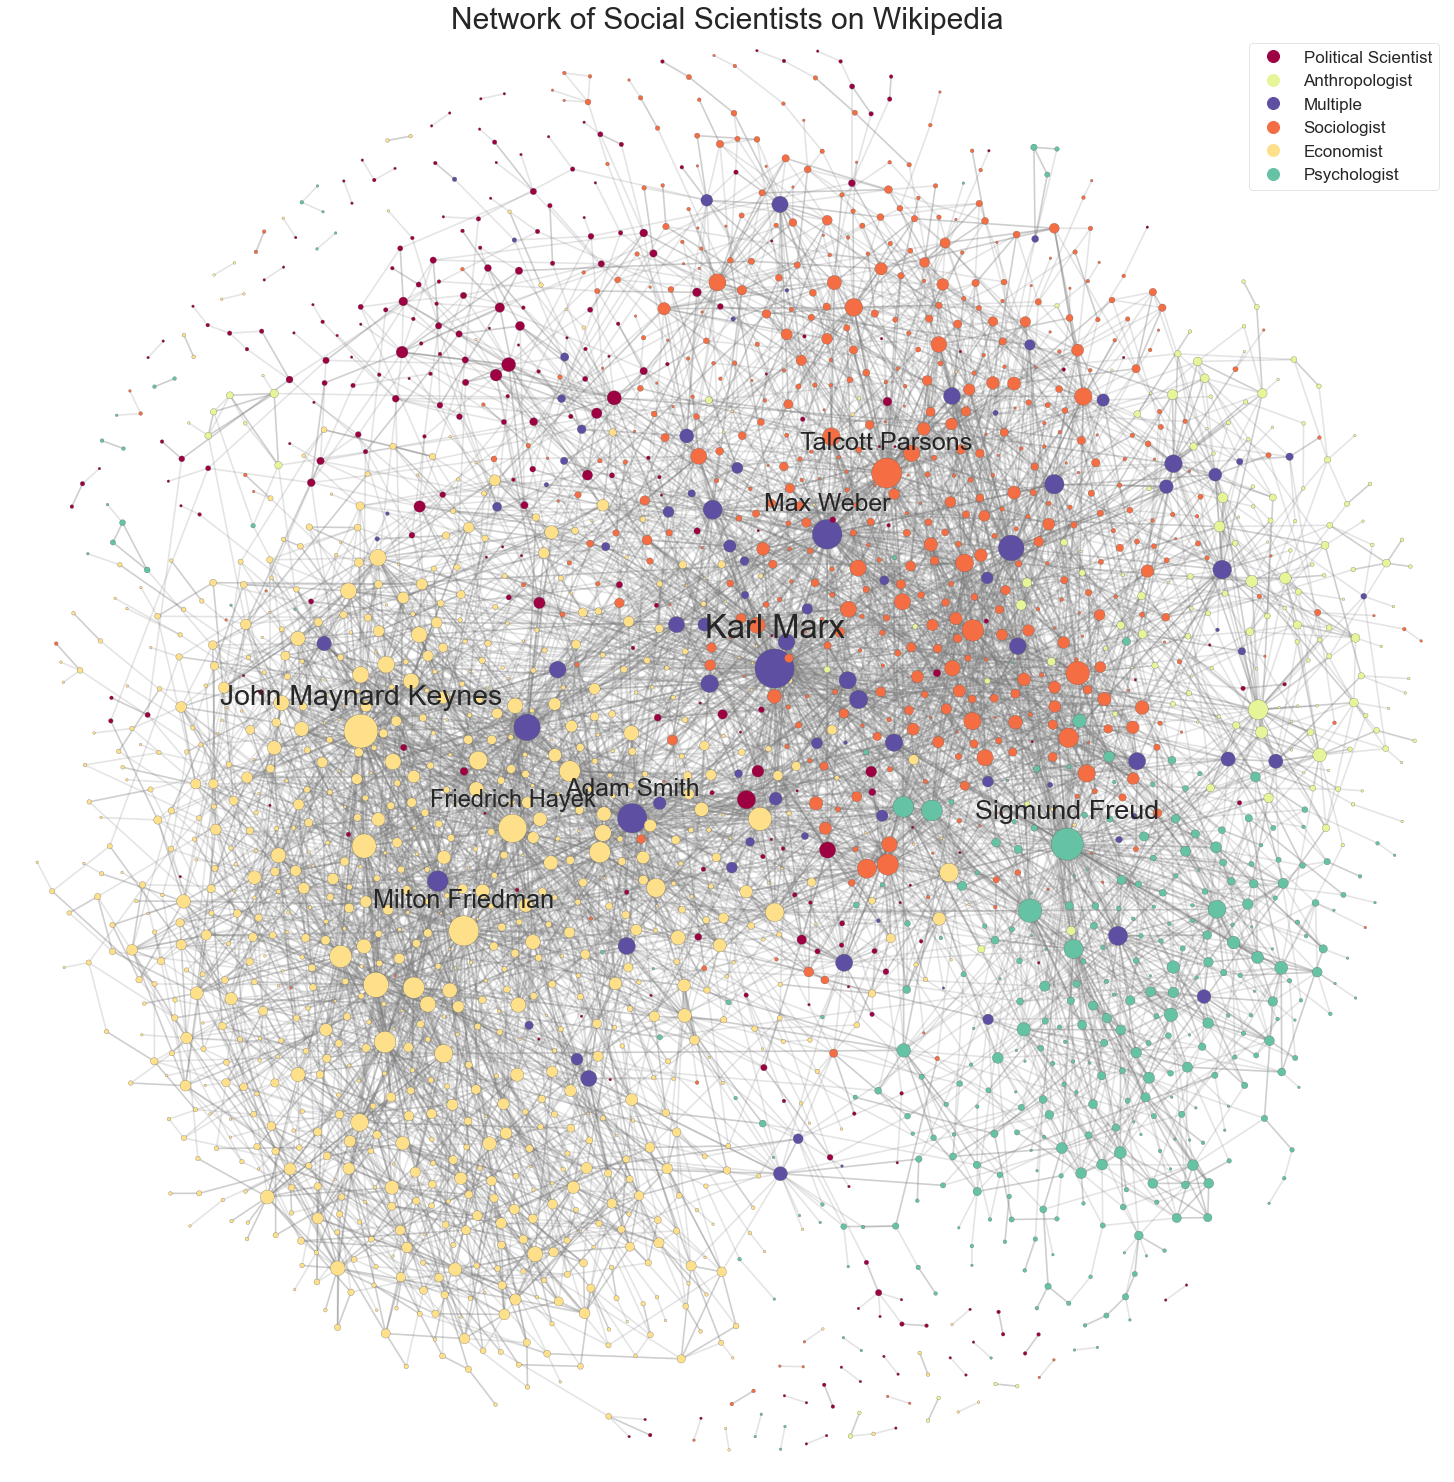

In [18]:
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-white')

# Drawing a big figure
plt.rcParams["figure.figsize"] = (20,20)

# Drawing the network
fig, ax = nw.draw_netwulf(network)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>7.5:
        nw.tools.add_node_label(ax,
                                network,
                                dy = network['nodes'][node_nr]['radius']*2,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*3)
    else:
        pass


val_map = {inv_science_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)

plt.legend(fontsize = 17, frameon=True, framealpha=1)

ax.set_title('Network of Social Scientists on Wikipedia', size = 30)
# Saving as pdf
#plt.savefig('Plots/field_network_title.png', dpi=None, facecolor='w', edgecolor='w', bbox_inches='tight')

In the plot above, the nodes are colored based on their affiliated scientific diciplines. We have removed singleton nodes from the networks and included the names of the highest degree nodes. <br><br>

With a background in sociology and anthropology, we recognize many of the names of the highest degree nodes. We see that all scientific disciplines, aside from Anthropology and Political Science, are represented with a labelled theorist. Thus, Sociology, Economy, and Psychology (and Multiple) have higher degree nodes than Anthropology and Political Science. <br><br>

We see that the network is somewhat divided into the conventional 5 diciplines. However, there also appears to be quite a bit a mixing at the boarders of the discipline clusters. <br><br>

To further explore the network, we'll examine the degree distribution. 

In [6]:
''' Save the configuration for plotting the same network later,
    but with colors based on the community partition.'''
# with open("network_configurations/big_network.json", 'w') as f:
#     json.dump(network, f)
    
# with open("network_configurations/big_config.json", 'w') as f:
#     json.dump(config, f)

' Save the configuration for plotting the same network later,\n    but with colors based on the community partition.'

### Degree Distribution of the Network <a name="deg_dist"></a>

In this section, we'll explore the in- and out-degree distribution.

In [6]:
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-white')

''' Function to plot Degree distribution '''
def plot_deg_dist(deg_seq, title = 'Degree distribution', save = False, save_title = "", kwgs = {}):
    plt.style.use('ggplot')
    
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    
    sns.scatterplot(x=deg_seq.keys(), y=deg_seq.values(), ax = ax[0], **kwgs)
    ax[0].set_title(title)
    ax[0].set_ylabel('Frequency', size = 15)
    
    del deg_seq[0] # messes up the log plot so remove 0 deg nodes 
    sns.scatterplot(x=deg_seq.keys(), y=deg_seq.values(), ax = ax[1], **kwgs)

    ax[1].set_title(title + ' (log scaled)')
    ax[1].set_ylabel('Frequency', size = 15)
    ax[1].set_xlabel('k', size = 15)
    # logscale the axes
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    
    if save:
        plt.savefig(f'Plots/{save_title}.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
    plt.show()

We plot the in- and out-degree distribution

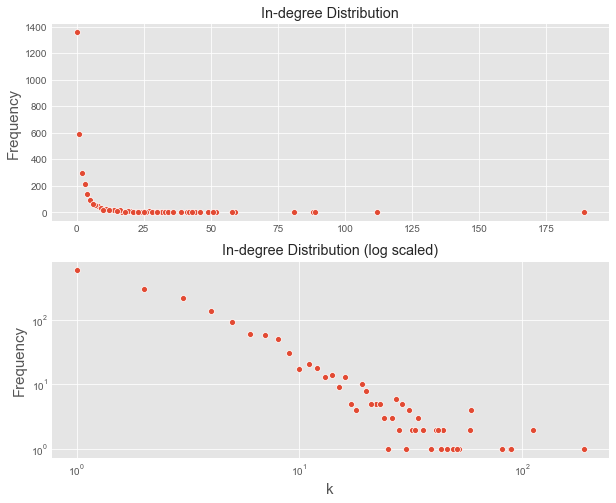

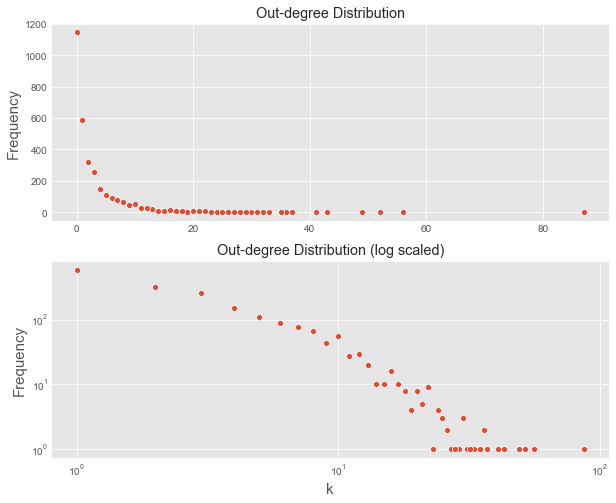

In [7]:
''' Plot degree distribution '''
import seaborn as sns
from collections import Counter

# Get in and out degree
in_deg_dist = Counter([d for n,d in G.in_degree()])
out_deg_dist = Counter([d for n,d in G.out_degree()])

# Plot and save 
plot_deg_dist(in_deg_dist, 'In-degree Distribution', save=False, save_title="in_deg_dist")
plot_deg_dist(out_deg_dist, 'Out-degree Distribution', save=False, save_title= "out_deg_dist")

Both the in- and out-degree distribution appears to be powerlaw distributed, meaning that the growth of the network is linearly biased by the degree distributions of the pre-existing nodes in the network. This is indicated by the presence of few very high degree nodes, while most of the nodes have a much smaller degree in comparison. We calculate the degree exponent to see if the degree distribution is acually following a powerlaw. 

In [8]:
import powerlaw

# list of degrees
deg_in = [_ for _key, _ in dict(G.in_degree()).items()]
deg_out = [_ for _key, _ in dict(G.out_degree()).items()]
# Calc exponent
print('Degree exponent for in-degrees:', powerlaw.Fit(deg_in, verbose = False).alpha)
print('Degree exponent for out-degrees:', powerlaw.Fit(deg_out, verbose = False).alpha)

Degree exponent for in-degrees: 2.5693308119051164
Degree exponent for out-degrees: 4.403722203175794


The in-degree distribution is indeed in the scale free region, with $\gamma$ = 2.56. However, the degree exponent for the out-degree distribution is $\gamma$ = 4.40, which means that it is in the random network regime, as $\gamma$ > 3 (Barabassi section 4.7). 

To futher explore the hubs created by the scale free property of the networks in-degree distribution, we plot the most connected nodes in the following section.  

#### Plot the most connected nodes based on in- and out- degree <a name="top_nodes"></a>

In this section, we plot the most connected nodes, both with regard to in- and out-degree, to get a better understanding of the networks scale free property. 

In [9]:
''' Plot the top X out- and in- degree nodes '''
def plot_top_nodes(top_n = 50, in_deg = True, save=False, save_title = ""):
    if in_deg:
        top_nodes = sorted(dict(G.in_degree()).items(), key = lambda x: x[1], reverse = True)[:top_n]
    else:
        top_nodes = sorted(dict(G.out_degree()).items(), key = lambda x: x[1], reverse = True)[:top_n]
    x = [_[0] for _ in top_nodes]
    y = [_[1] for _ in top_nodes]

    fig, ax = plt.subplots(figsize = (12,6))
    sns.scatterplot(x,y, ax=ax)
    ax.set_ylabel('Degree', size = 15)
    plt.xticks(rotation=90, size = 12)
    if in_deg:
        ax.set_title(f'Distribution of in-degree for top {top_n}', size = 15)
    else:
        ax.set_title(f'Distribution of out-degree for top {top_n}', size = 15)
        
    # Saving as pdf
    if save:
        plt.savefig(f'Plots/{save_title}.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
    plt.show()

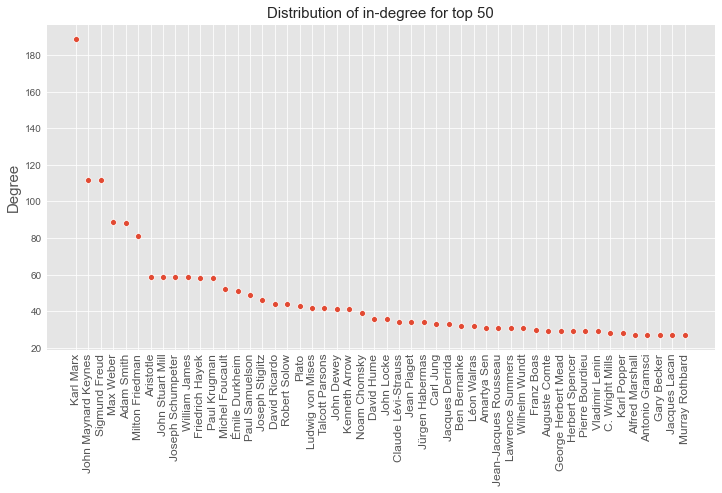

In [10]:
''' Call function '''
plot_top_nodes(in_deg = True, save_title="top_in_deg")

**Highest In-degree Nodes**

Looking at the most connected nodes with regard to in-degree, we see many of the "founding fathers" of the social science disciplines. The most connected node is Karl Marx, the developer of the highly influential mode of state governance, "Communism", and a central figure in both sociology and economy. The second most connected node is John Maynard Keynes - a highly influential economist - followed by Sigmund Freud who pioneered psychoanalysis.

This might explain the powerlaw distribution of the in-degrees. Generally, we see that most of the high in-degree nodes are "older" or "classical" theorists. It makes sense that many of the newer theorists tend to either draw inspiration from or stand in opposition to the "classical" theorists, who established entire theoretical traditions and analytical approaches like Marxism, Keynesian, Freudian, Weberian, and economic liberalism, to name a few. Thus, the scale-free property of the network becomes apparent, because of the preferential attachment of new theorists. 

**Fun fact**, within the social sciences, a concept very similar to the scale-free network property was developed by the sociologist <a href="https://www.science.org/doi/10.1126/science.159.3810.56" target="_blank">Robert Merton in 1968</a>. He called it "The Matthew Effect", and it concerned a "rich-get-richer" mechanism with regard to recognition in the scientific community. Years later, in 1999, Barabasi & Albert identified a similar mechanism within the field of network science, namely the scale-free powerlaw distribution of many real world networks <a href="https://www.researchgate.net/publication/12779869_Albert_R_Emergence_of_Scaling_in_Random_Networks_Science_286_509-512" target="_blank">(Barabasi & Albert 1999)</a>.

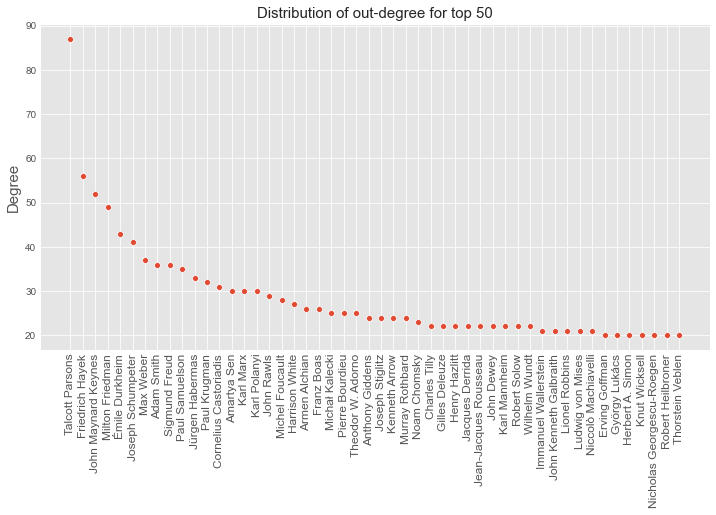

In [11]:
plot_top_nodes(in_deg = False, save_title="top_out_deg")

**Highest Out-degree Nodes**

Based on the degree exponent, we saw that the out-degrees do not follow a power-law, but are in the random network regime. Arguably, a degree exponent of $\gamma$ = 4.40 is in the vicinity of the scale-free regime compared to the degree exponent of a completely random network. Thus, we see that there are particularly high degree nodes (hub-like), such as Parsons, Hayek and Keynes. 

It sort of makes sense, that the out-degrees do not have the scale-free property, while the in-degree do. The in-degree is an accumulation of all the wikipages, while the out-degree is only based on a single wiki-page. However, one must give Parsons credit for his tenacious effort at mentioning nearly 90 people.  

### Conclusion on  Basic Statistics <a name="conc_base"></a>

In this section, we have presented our data extration and cleaning process. Based on five Wikipedia lists of prevalent social scientists, we have extracted 2 dataset: 
- 1) An edge- and nodelist for constructing a directed network, where an edge is created if a scientist is mentioned on another scientist's Wikipedia-page. 

- 2) Text data from each of the scientists' Wikipedia-page, which will be used to calculate both TF-IDF scores, as well as a hSBM model.


Further, we presented basic descriptive statistics of our network of social scientists, which consists of 3090 nodes and 8984 edges.

We saw that the in-degrees in the network are powerlaw distributed, and argued that this makes sense, as most of the high in-degree nodes are "classical" theorists. New theorists will probably tend to either build on or critize these "classical" theorists, introducing the preferential attachment mechanism and a scale-free property to the networks in-degrees.

Lastly, we stated that the out-degrees were in the random network regime, based on the degree exponent. The fact that the out-degrees do not have the scale-free property, while the in-degree do, is probably because the in-degree is an accumulation of all the wikipages, while the out-degree is only based on a single wiki-page.

# Tools, theory, and analysis. Describe the process of theory to insight <a name="analyse"></a>

This section is structured in three parts. [Firstly](#communities), we examine the wiring structure of the network, using Louvain Partition to identify communities. [Secondly](#TF-IDF), we use the [Wikipedia-text content](#text_analyses) gathered for each social scientist to calculate TF- and TF-IDF scores both within disciplines, and within the identified communities. [Thirdly](#HSBM), we use the text data to estimate a hSBM model and examine which topics are most prevalent both within disciplines and communities.

### Communities <a name="communities"></a>
In this section, we use Louvain partition to [identify communities](#com_detect) in the networks wiring structure.  [First](#com_size), we will look into the sizes of the identified communities, as well as the most prevalent nodes within each community. [Subsequently](#com_nx), we will plot the network with the nodes color based on their community affiliation, and compare it with the [discipline network](#construct_network). 

#### Louvain Partition

To detect communities, we use the Louvain algorithm, which we explain in detail below:


The Louvain algorithm partitions the network by finding the partition that optimizes modularity, defined as <a href="http://networksciencebook.com/chapter/9#modularity" target="_blank">(Barabási eq. 9.12)</a> : $M = \sum_{c=1}^{n_c}\left[\frac{L_c}{L}-\left(\frac{k_c}{2L}\right)^2\right]$, where $n_c$ is the number of communities/partitions, $L$ is the total number of links in the network, $L_c$ is the total number of links within community $C_c$, and $k_c$ is the total degree of the nodes in this community (including links to nodes outside community $C_c$). The Louvain algorithm works in 2 steps:
- **1) Modularity optimization**: Each node in the network is assigned to its own community. Sequentially, each node, $i$, is moved to the neighboring community, $j$, that leads to the maximum change in modularity, $\Delta M$. This is done repeadtly and sequentially until $\Delta M = 0$, i.e. there is no change in modularity by moving any node to another community.  The change in modularity, when moving node $i$ from one community to another, is calculated as (Barabási eq 9.58);
    
     $$\Delta M=\left[\frac{\sum_{in}+2k_{i,in}}{2W} - \left(\frac{\sum_{tot}+k_{i}}{2W}\right)^2 \right] - \left[\frac{\sum_{in}}{2W} - \left(\frac{\sum_{tot}}{2W}\right)^2 - \left(\frac{k_{i}}{2W}\right)^2 \right] $$
     
    where $\sum_{in}$ is the sum of all the weights of links inside the community, $C_j$, that $i$ is moved into (=$L_{C_{j}}$ in an undirected network); $\sum_{tot}$ is the sum of all the weights of the links to nodes in $C_j$; $k_i$ is the weighted degree of $i$; $k_{i,in}$ is the sum of the weights of the links between $i$ and other nodes in $C_j$; and $W$ is the sum of the weights of all links in the network. If $\Delta M < 0$, $i$ stays in its current community. 
- **2) Community Aggregation**: A weighted network is created as an aggregate of the communities from the previous step: The nodes in the weighted network are the communities from step 1, the edge weights are the sum of edges between communities, and edges within a community becomes 2 self-loops.

When the network of step 2 has been created, step 1 and 2 can be repeated on the new network until there is no increase in modularity. Collectively, the 2 steps are called a pass <a href="http://networksciencebook.com/chapter/9#advanced-9c" target="_blank">(Barabási Chap. 9)</a>.

The 2 steps in the Louvain Algorithm are depicted below, where they are repeated for 2 passes 
<a href="http://networksciencebook.com/chapter/9#advanced-9c" target="_blank">(Barabási Image 9.37)   </a>:
<img src="louvain.jpg" alt="drawing" style="width:750px;"/>

#### Community Detection <a name="com_detect"></a>

Having explained the Louvain algorithm, we are ready to code out our community detection. 

In [19]:
import community

# How many communities including all nodes?
partition_all_n = community.best_partition(G.to_undirected(), random_state = 280395)
print("N communities when including all nodes: ",len(set(partition_all_n.values())))

# How many nodes with 0 degree
print("Singleton nodes: ", len([d for n,d in dict(G.degree()).items() if d == 0]))

''' Only the GCC, otherwise there will be about 300+ communities '''
G_c = G.copy()
c = max(nx.weakly_connected_components(G_c), key=len) # largest connected component
GCC = G_c.subgraph(c).copy() # make subgraph of the largest connected component
G_undir = GCC.to_undirected().copy() # undirected

# Louvain modularity for partition
partition = community.best_partition(G_undir, random_state = 280395)
print("N communities in GCC: ",len(set(partition.values())))

N communities when including all nodes:  956
Singleton nodes:  889
N communities in GCC:  22


As the output from the above cell shows, it would not make much sense to include all the nodes from the network, as that would result in 956 detected communities. This is mostly due to the 889 singleton (degree 0) nodes. To avoid community inflation, we extract the giant connected component (GCC) and use that to identify communities. That gives us 22 identified communities.

Next, we'll examine the community sizes as well as the most connected nodes within each community.

#### Community Size <a name="com_size"></a>

We plot the size of the identified communities. We name the communities based on the 3 most connected nodes within each community. 

Share of nodes in the 8 largest communities: 0.97


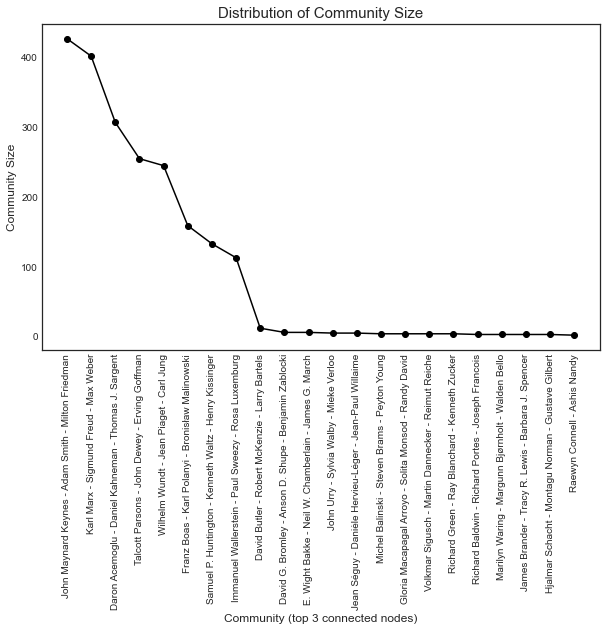

In [20]:
import regex as re
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-white')

com_dict = {_com:{n for n, d in partition.items() if d == _com} for _com in range(max(partition.values())+1)}

''' Rename communities after their 3 most connected nodes '''
def sort_dict(_dict, reverse = False):
    return (dict(sorted(_dict.items(), key=lambda x: x[1], reverse = reverse)))

named_com_dict = com_dict.copy()
# loop over community and their nodes 
for _com, _nodes in com_dict.items():
    # dictionary with {node:degree}
    node_degree_dict = {node:G_undir.degree()[node] for node in _nodes}
    # sort based on degree
    node_degree_dict = sort_dict(node_degree_dict, reverse = True)
    # Get the 3 most connected
    top_3_connected = list(node_degree_dict.keys())[:3]
    # Turn the top 3 into a single string + remove the extentions of very long names link Esben, the first of the seas 
    top_3_connected = ' - '.join([str(n).split(',')[0] for n in top_3_connected])
    # remove parentheses like Sune (Social Data Scientist)
    top_3_connected = re.sub(' \(.*?\)', '', top_3_connected)
    # rename the community after the 3 most connected nodes 
    named_com_dict[top_3_connected] = named_com_dict.pop(_com)
    # Rename the community names in the partition dict
    for node in _nodes:
        partition[node] = top_3_connected

com_size_dict = {_com:len(nodes) for _com, nodes in named_com_dict.items()} # get com_size
com_size_dict = sort_dict(com_size_dict, reverse = True) # sort dict 

top_8_com = sum(list(com_size_dict.values())[:8]) / sum(list(com_size_dict.values()))
print(f'Share of nodes in the 8 largest communities: {round(top_8_com,2)}')

plt.rcParams["figure.figsize"] = (10,6)

x = list(com_size_dict.keys())
y = list(com_size_dict.values())
plt.plot(x,y, marker='o', c='black')
plt.xticks(rotation=90)
plt.xlabel('Community (top 3 connected nodes)', size = 12)
plt.ylabel('Community Size', size = 12)
plt.title('Distribution of Community Size', size = 15);
#plt.savefig(f'Plots/community_size.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')

We immediately notice a big variation in size, with the largest community consisting of more than 400 scientists and the smallest of just two scientists. Overall, the 8 largest communities contain nearly all of the scientists (97%).

Looking at the three highest degree nodes within each of the communities, we see that the largest and third largest communities are centered around economists, with Keynes, Smith, and Friedman, and Kahneman, Acemoglu, and Mankiw as their respective highest degree nodes. From the community size plot alone, it is hard to tell whether the rest of these two communities' nodes are also economists - to explore that, we will have to look more into the [community network plot](#com_nx), which we'll do later. 

Regarding the other disciplines, most of them seem to be represented among the top 3 connected nodes in a community:
-	Wundt, Piaget, and Jung are all psychologist. 
-	Malinowski, Polanyi, and Boas are all anthropologist.
-	Kissinger, Waltz, and Huntington are all political scientists. 

Sociology is missing a clear cut community. However, the fourth largest community with Parsons, Dewey, and Goffman could represent a community of sociologists. Eventhough John Dewey is a psychologist by training, he was mostly occupied with social psychology which is close to sociology. But, once again, we'd have to look deeper into the rest of the community nodes to conclude more. 

The second largest community have Marx, Freud, and Weber as its highest degree nodes. Both Marx and Weber appear on more than one of the social science Wikipedia-lists, and are therefore classified as "Multiple", which makes them a bit more difficult to interpret. The "Multiple" category will be discussed further in [the discussion](#discussion), and throughout the analysis, when relevant. However, it would be difficult to ascribe either one to a single discipline. On [Weber's](https://en.wikipedia.org/wiki/Max_Weber) Wikipedia-page he is affiliated with sociology, history, law, and political economy, while [Marx](https://en.wikipedia.org/wiki/Karl_Marx) is both sociologist, economist, historian, and philosopher on his Wikipedia-page. That they are both in the same community might indicate that this community does not follow the norm of a singular affilation with either of the five social science disciplines. 

With regard to Freud, who is also in the Marx-Weber community, both Marx and Freud are known for the <a href="https://en.wikipedia.org/wiki/Hermeneutics_of_suspicion" target="_blank"> hermeneutics of suspicion</a>, eventhough Freud is clearly categorizable as a psychologist. Hermeneutics of suspicion is a philosophical tradition, which might further hint that the community is not easily definable as clearly anthroplogy, sociology, political science, economy, or psychology. 


In the next section, we'll plot the community network, to get a better idea of how the rest of the community nodes a distributed and structered in the network. 

In [15]:
# Dict with name as key and field and community dicts as values 
# Used in the HSBM analysis
joined_dict = {name:{'field':inv_science_dict[name], 'community':com}\
               for name, com in partition.items()}

In [ ]:
with open('name_field_community.json', 'w', encoding = 'utf-8') as f: 
    json.dump(joined_dict, f)
    
# Save com sizes for index sorting 
with open('com_size_dict.json', 'w', encoding = 'utf-8') as f: 
    json.dump(com_size_dict, f)

#### Community Network <a name="com_nx"></a>

We plot the GCC network twice - once partitioned by the identified communities, and once by the disciplines. We use the function `redefine_attr` to allign their colormaps. 

Text(0.5, 1.0, 'Discipline Network')

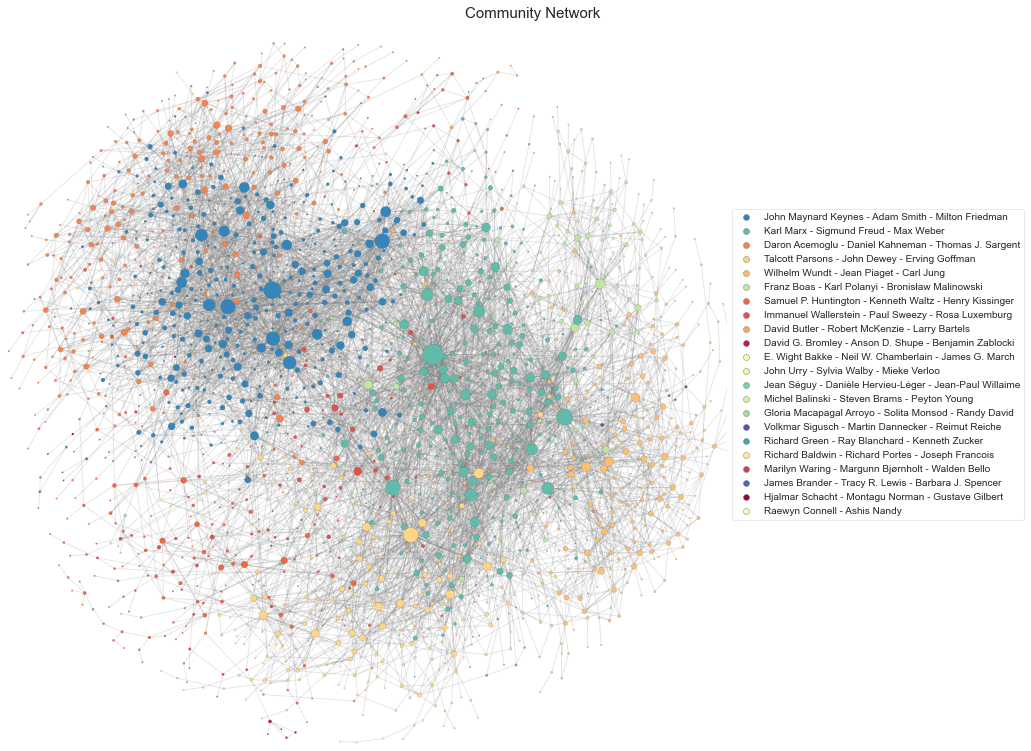

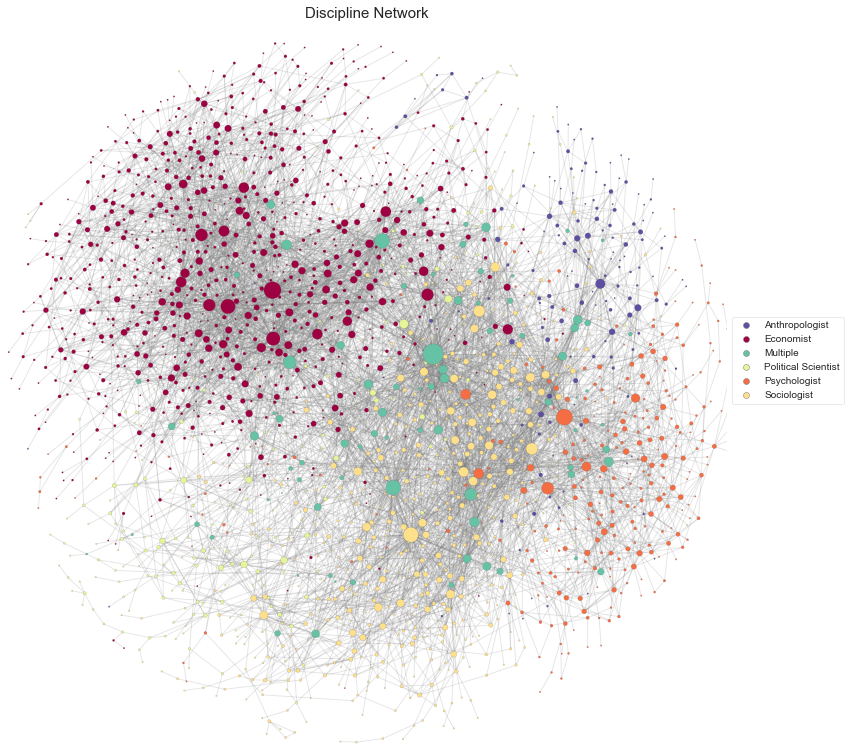

In [82]:
''' Plot community partition '''
nx.set_node_attributes(G_undir, partition, name = 'group') # node attributes 
## Use the configs from the big non-GCC network
config['zoom'] = 0.745 # rearrange zoom config
network_part, config_part = nw.visualize(G_undir, plot_in_cell_below=False, config = config)
# Recolor based on Spectral colormap 
network_part = redefine_attr(network_part, partition)

fig, ax = nw.draw_netwulf(network_part, figsize = 10)

# {community:color} dict for the legend
val_map = {partition[node['id']]:node['color'] for node in network_part['nodes']}

# Add legends
for v in sorted(val_map.keys()):
    plt.scatter([],[],color=val_map[v], 
                label=v, 
                marker='o',
                edgecolors= "grey",
                linestyle="None")
    
# Sort and Place legend
handles, labels = plt.gca().get_legend_handles_labels()
# Get the order of the legend - Based on community size 
order = [labels.index(_com) for _com in list(com_size_dict.keys())]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           bbox_to_anchor = (1,0.75), frameon=True)

# Ugly, but works 
plt.title('Community Network', x = 0.73, size = 15)


''' Plot discipline partition on GCC '''
nx.set_node_attributes(G_undir, inv_science_dict, name = 'group') # node attributes 
## Use the configs from the big non-GCC network
network_part, config_part = nw.visualize(G_undir, plot_in_cell_below=False, config = config)

# Recolor based on Spectral colormap 
network_part = redefine_attr(network_part, inv_science_dict)

fig, ax = nw.draw_netwulf(network_part, figsize = 10)

# {community:color} dict for the legend
val_map = {inv_science_dict[node['id']]:node['color'] for node in network_part['nodes']}

# Add legends
for v in sorted(val_map.keys()):
    plt.scatter([],[],color=val_map[v], 
                label=v, 
                marker='o',
                edgecolors= "grey",
                linestyle="None")
# Place legend
plt.legend(frameon=True,
           bbox_to_anchor = (1,0.6))

plt.title('Discipline Network', size = 15)

In the above figures of the network the different sizes of the communities become clear, with the two largest networks being easily observable in the center, and the smallest networks being hard to distinguish. Comparing the community network with the discipline network, the communities seem to follow the disciplines rather closely. <br><br>


As mentioned in [community size](#com_size), the largest and third largest communities appear to be centered around economists, as both communities had economists as their 3 highest degree nodes. Comparing the community network and discipline network, it becomes apparent that the rest of the two communities' nodes are also economists. We have thus further nuanced the economic discipline, as it can be subdivided into two exclusive economist communities. In [TF-IDF](#TF_IDF) we will examine whether these two economist communities are also distinguishable with regard to the text content on their Wikipedia-pages. <br><br>
 
Furthermore, it also seems that the large sociology cluster in the discipline network has been split in two. One part constitutes much of the second largest community (Marx, Freud, and Weber), while the other part is placed in the fourth largest community (Parsons, Dewey, and Goffman).  <br><br>

We see that the anthropological discipline is clearly identified by the Boas-Polanyi-Malinowski community. Psychology is detected nicely by the Wundt-Piaget-Jung community, and political science have most of its nodes placed in the Huntington-Waltz-Kissinger community.<br><br>

Both the subdivision of the sociological and economic discipline contains many of the "Multiple" nodes. 

#### Conclusion on Communities <a name="conc_com"></a>

In this section, we have examined the wiring structure of the network, using Louvain Partition to identify communities. We identified 22 communities, and compared them to the network partition made by the established social science disciplines. Overall, the largest communities partitioned the network very similarly to the discipline partition. However, using community detection, we identified a potential to further nuance the disciplinary boundaries. We identified two communities within both the economic discipline, as well as the sociological discipline, both of which contained many of the nodes classified as "Multiple". <br><br>


In [the next sections](#TF_IDF), we will examine the identified communities to see if they represent a meaningful distinction with regard to the text content on the Wikipedia-pages. 

### TF-IDF  <a name="TF_IDF"></a>

In this section, we will delve deeper into the textual content of both the disciplines and the identified communities. [First](#TF_IDF_def), we present the concepts of TF- and TF-IDF scores as a method for identifying the most definitory and distinguishing words in a series of documents. [Subsequently](#TF_IDF_scores), we calculate and interpret the TF- and TF-IDF scores both within disciplines and within the identified communities.

#### What is TF-IDF?  <a name="TF_IDF_def"></a>

In this section, we present the concept of TF- and TF-IFD.

There is a variety of ways to calculate TF-IDF. We calculate TF-IDF in what appears to be the most conventional way, where the raw count, $f_{t,d}$, of term $t$ in document $d$ is standardized/adjusted by the document length, $\sum_{t'\in{d}}f_{t',d}$, e.i. adjusted by the raw count of all the terms, $t'$, in $d$. Thus, $TF(t,d)$ becomes the share of words in $d$ that is $t$. The equation for the standardized raw count (term frequency) is:
$$TF_{t,d}=\frac{f_{t,d}}{\sum_{t'\in{d}} f_{t',d}}$$
    
 Further, we use the inverse document frequency, IDF, to diminish the weight of terms that occur frequently across all documents and increase the weight of terms that are unique to a few documents. IDF is calculated as: 
$$idf(t,D)=log\left(\frac{N}{\{d\in{D}:t\in{d}\}|}\right)$$
     
 where $N$ is the number of documents, and ${\{d\in{D}:t\in{d}\}|}$ is the number of documents the term $t$ appears in (As our vocabulary is based on the words of the documents, we do not need to worry about a scenario where a term doesn't appear in any of the documents, which would otherwise  result in a division by 0). 
 
 TF-IDF is simply the product of TF and IDF:
$$TFIDF(t,d,D) = TF\bullet idf$$
     
 Thus, if a term appears in all the documents, its weight in all the documents will be reduced to 0, as:  $\frac{N}{\{d\in{D}:t\in{d}\}|} = 1 \rightarrow IDF=log(1)=0$. Further, if a term does not appear in a document, its weight in that document will also be reduced to 0, as $f_{t,d}=0$. On the other hand, a high weight in TF–IDF is reached by a high term frequency (in the given document) and a low document frequency of the term in the whole collection of documents.


### TF-IDF Scores  <a name="TF_IDF_scores"></a>

Now that we have an understanding of TF-IDF, we can code it out. [In the section below](#preproc), we preprocess the text content data, and split it into discipline documents and community documents, respectively. Then, we code out function to calculate TF- and TF-IDF scores.   

#### Preprocessing and Documents Creation  <a name="preproc"></a>

First, we set up a preprocessing function, which entails tokenizing, stop-word removal, and lemmatizing.

In [2]:
import json
''' Import dictionaries with communities and text, if the entire code has not been run beforehand '''
with open(f'wiki_dict_noname.json','r', encoding = 'utf-8') as f:
    name_txt = json.load(f)
    
with open(f'name_field_community.json','r', encoding = 'utf-8') as f:
    name_field_com = json.load(f)
    
def preprocess(text, remove_stopwords=True):
    import nltk
    import string 
    from nltk.corpus import stopwords

    # import stopwords
    stop_words_list = stopwords.words("english")

     # 1) Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    if remove_stopwords:
        # 2) Remove stopwords and tokenize
        tokens = [token for token in nltk.word_tokenize(text.lower()) if token not in stop_words_list]
    else:
        # 2) Tokenize
        tokens = [token for token in nltk.word_tokenize(text.lower())]

    # 3) Lammetize = convert words to their root (running -> run)
    wnl = nltk.WordNetLemmatizer() 
    lemmas = [wnl.lemmatize(t) for t in tokens] 
    return lemmas # return a list of stems/lemmas

We create two dataset by spliting the text into each discipline (`field_dict`) and into each community (`com_dict`). Thus, we treat each disciplines as a document in `field_dict` and each community as a document in `com_dict`.

In [3]:
#Dictionaries where the wiki-text is split based on scientific field, and community. 
# Empty dicts 
field_dict = {val['field']:[] for _key, val in name_field_com.items()}
com_dict = {val['community']:[] for _key, val in name_field_com.items()}

cnt = 0
for name, txt in name_txt.items():
    if name in name_field_com.keys():
        cnt += 1
        _key = name_field_com[name]['field']
        txt = preprocess(txt) # preprocess 
        field_dict[_key] += txt      

cnt = 0
for name, txt in name_txt.items():
    if name in name_field_com.keys():
        cnt += 1
        _key = name_field_com[name]['community']
        txt = preprocess(txt) # preprocess 
        com_dict[_key] += txt      

#### TF-IDF Functions

We have the preprocessed text data split into discipline documents and community documents. Next, we calculate the TF- and TF-IDF scores. In the code-block below, we set up functions to calculate TF- and TF-IDF.

In [27]:
import math
# We define function for the tf-idf - we use them through the assignment
''' Used throughout the assignment '''
def sort_dict(_dict):
    return (dict(sorted(_dict.items(), key=lambda x:x[1], reverse = True)))

''' We set up the needed functions: TC, TF and IDF + A preprocessing function '''
def _TC(_tokens):
    ''' Returns a dict with words as keys and their frequency in the document as values '''
    unique_words = set(_tokens) # unique words
    freq_dict = dict.fromkeys(unique_words, 0) # empty dict with each unique word as key and with val=0
    for word in _tokens:
        freq_dict[word] += 1 # count the words 
    return freq_dict


def computeTF(_tokens):
    ''' Input is a tokenized document. 
    Output is a dict with unique words, sorted by TF in descending order '''
    bagOfWords = _TC(_tokens) # call BoW/TC function
    tfDict = {} 
    bagOfWordsCount = sum(bagOfWords.values()) # count number of words = sum of the frequencies 
    for word, count in bagOfWords.items(): # loop over the words and their frequnecy
        tfDict[word] = count / float(bagOfWordsCount)
    # Sort based on TF-value
    return sort_dict(tfDict)

def computeIDF(documents):
    ''' The input should be a dictionary where the keys are the documents and the values
    are the tokenized content belonging to the documents '''
    N = len(documents) # count number of documents 
    vocab = set([_w for _race, txt in documents.items() for _w in txt]) # Get the entire vocab from all docs
    idfDict = dict.fromkeys(vocab, 0) # dict with words as keys and count/val set to 0

    for document, txt in documents.items(): # loop over the documents/keys and their content/values
        _bow = _TC(txt) # create bag_of_words/TC for the document
        for word, val in _bow.items(): # loop over every unique word in the document 
            idfDict[word] += 1 # increment by one, for each document the word appears in 
            
    # for all the words in the vocab/corpus and the number documents they appear in 
    for word, val in idfDict.items(): 
        idfDict[word] = math.log(N / float(val)) # calculate the idf for each word 
    return idfDict

def calc_tf_idf(document_content_dict, tc_instead = False):
    ''' The input should be a dictionary where the keys are the documents and the values
    are the tokenized content belonging to the documents '''
     # get vocab across all documents 
    vocab = set([_w for _com, txt in document_content_dict.items() for _w in txt])
    _idf = computeIDF(document_content_dict) # compute idf of the documents 
    tf_idf_list = [] # list to append lists of tf_ids's to, for each community
    for _com, _txt in document_content_dict.items(): # loop over the documents 
        com_tf = computeTF(_txt) # calc the com's tf 
        if tc_instead:
            com_tf = _TC(_txt) # if the TC is needed instead of the TF
        
        # loop over the words in the communities vocab
        # if the word is in the com_corpus, calc tf_idf - otherwise return 0 
        tf_idf = [_idf[_w] * com_tf[_w] if _w in com_tf.keys() else 0 for _w in vocab]
        tf_idf_list += [tf_idf] # append the row --> one row for each race      

    # Create tf_idf df (or tc_idf, if that was chosen)
    tf_idf_df = pd.DataFrame(tf_idf_list,
                             index=document_content_dict.keys(),
                             columns = set([_w for _com, txt in document_content_dict.items()\
                                            for _w in txt])).transpose() # transpose 
    if tc_instead:
        return round(tf_idf_df) # round to nearest whole number
    return tf_idf_df

We call the functions

In [28]:
# Calculate Tf-idf for community and scientific field
field_tf_idf = calc_tf_idf(field_dict)
com_tf_idf = calc_tf_idf(com_dict)

#### TF- and TF-IDF Scores for Disciplines and Communities

Below, we present the 5 highest ranking words within and across discipline documents and community documents. 

But first, we import the dictionary with community sizes to sort the index in TF- and TF-IDF tables. 

In [29]:
import json 
# import community sizes 
with open('com_size_dict.json', 'r', encoding = 'utf-8') as f: 
    com_size_dict = json.load(f)

##### TF scores - Discipline

In [30]:
print('The top 5 words in each scientific field based on tf')
# calc top 5 tf ranks for each community 
l = [list(computeTF(_txt))[:5] for _com, _txt in field_dict.items()] 
# to df 
_df = pd.DataFrame(l, index = field_dict.keys())
_df.columns = range(1,6) # rename columns 
_df = _df.rename_axis('↓ Scientific Field', axis = 0)
_df = _df.rename_axis('Rank of word based on TF →', axis = 1).sort_index()

''' save df as html table '''
# with open('html_tables/field_tf.html', "w", encoding='utf-8') as f:
#     f.write(_df.to_html().replace('border="1"','border="0"')) # set border = 0, to make it prettier
_df

The top 5 words in each scientific field based on tf


Rank of word based on TF →           1             2           3  \
↓ Scientific Field                                                 
Anthropologist              university  anthropology    american   
Economist                    economics      economic  university   
Multiple                        social          work  university   
Political Scientist         university     political    american   
Psychologist                psychology    university        work   
Sociologist                 university        social   sociology   

Rank of word based on TF →              4        5  
↓ Scientific Field                                  
Anthropologist                       work      new  
Economist                          theory      new  
Multiple                          society   theory  
Political Scientist         international  science  
Psychologist                     research   theory  
Sociologist                          work      new

Generally, the words with the highest TF scores seem somewhat intuitive and uninformative. For all the disciplines, some of the most prevalent words are 'university' and some conjugation of the discipline itself, like `anthropology` for Anthropologists, `economics` for Economists and so on. This seems resonable, as most of the Wikipedia-pages problem says something along the lines of "{Name} is a {Discipline} at {some university}". <br><br>


The `multiple` category contains rather broad and generic words like "social", "work", "society", and "theory", which are quite hard to interpret.<br><br>


In conclusion, the TF scores do not bring much nuance to the disciplines. Therefore, we hope to find a more substantive distinction between the content of the discplines by examining the TF-IDF. 

##### TF-IDF scores - Discipline

In [31]:
''' The 5 most important word for each scientific field based on TF-IDF'''

# get top 5 words for each top 5 community based on tf_idf
l =  [list(field_tf_idf[_field].sort_values(ascending=False)[:5].index) for _field in field_tf_idf.columns]

# to df 
_df = pd.DataFrame(l, index = field_tf_idf.columns)
_df.columns = range(1,6) # rename columns 
_df = _df.rename_axis('↓ Scientific Field', axis = 0)
_df = _df.rename_axis('Rank of word based on TF-IDF →', axis = 1).sort_index()

''' save df as html table '''
# with open('html_tables/field_tf_idf.html', "w", encoding='utf-8') as f:
#     f.write(_df.to_html().replace('border="1"','border="0"')) # set border = 0, to make it prettier
_df

Rank of word based on TF-IDF →            1               2              3  \
↓ Scientific Field                                                           
Anthropologist                      gorilla          apache           zuni   
Economist                       econometric    econometrics  macroeconomic   
Multiple                            khaldūn         habitus         samoan   
Political Scientist                 dodgson           arend     neorealism   
Psychologist                            apa  psychoanalytic  psychotherapy   
Sociologist                       wallpaper      sociologie   gemeinschaft   

Rank of word based on TF-IDF →          4               5  
↓ Scientific Field                                         
Anthropologist                   iroquois         olduvai  
Economist                       keynesian  macroeconomics  
Multiple                            hardt  psychoanalytic  
Political Scientist                   ndp             nsc  
Psychologist                      jungian         therapy  
Sociologist                        ortega          cyborg

Off the bat, the high scoring TF-IDF words carry more distinctive meaning between each discipline, than the TF words. <br><br>

Four of the five highest ranking words for anthropology are the names of indigenous groups, while the fifth word - `gorilla` - probably relates to biological anthropology. <br><br>

For the economists, `econometric(s)` - the quantative application of statistical models - is prevalent, along with `macroeconomic(s)`. Further, `keynesian` is a distinguishing word of the economic dicipline, refering to the analytical approach of John Maynard Keynes, who is one of the [highest degree nodes in our network](#top_nodes). <br><br>

The psychologists have words such as psychoanalytic, psychotherapy, Jungian, therapy and apa (American psychological association), which is also sensible. Sociologists have sociologie and gemeinschaft, which is probably a relic from the extensive German tradition within sociology. <br><br>

Regarding the ‘Multiple’ category, we see a mix of words. <a href="https://en.wikipedia.org/wiki/Ibn_Khaldun" target="_blank">Khaldun</a> is probably a reference to the Muslim philosopher of the 1400 century, who was the founder of the proto-disciplines that would later become sociology and economics. Further, ‘Multiple’ also contains the words `habitus`, which is a concept from Bourdieu (sociologist/anthropologist), and `psychoanalytic` a core concept from Freud (psychologist). The dissimilarity of these three words illustrate that the ‘Multiple’ category is indeed a mixed bag.

##### TF scores - Community

In [32]:
print('The top 5 words in each communities based on tf')

# Sort based on community size 
com_dict = dict(sorted(com_dict.items(), key=lambda x: com_size_dict[x[0]], reverse= True))

# calc top 5 tf ranks for each community 
l = [list(computeTF(_txt))[:5] for _com, _txt in com_dict.items()] 

# to df 
_df = pd.DataFrame(l, index = com_dict.keys())
_df.columns = range(1,6) # rename columns 
_df = _df.rename_axis('↓ Community', axis = 0)
_df = _df.rename_axis('Rank of word based on TF →', axis = 1)

''' save df as html table '''
# with open('html_tables/community_tf.html', "w", encoding='utf-8') as f:
#     f.write(_df.to_html().replace('border="1"','border="0"')) # set border = 0, to make it prettier
_df

The top 5 words in each communities based on tf


Rank of word based on TF →                                   1              2  \
↓ Community                                                                     
John Maynard Keynes - Adam Smith - Milton Friedman    economic      economics   
Karl Marx - Sigmund Freud - Max Weber               university           work   
Daniel Kahneman - Daron Acemoglu - Greg Mankiw      university      economics   
Talcott Parsons - John Dewey - Erving Goffman           social     university   
Wilhelm Wundt - Jean Piaget - Carl Jung             psychology     university   
Franz Boas - Karl Polanyi - Bronisław Malinowski    university   anthropology   
Samuel P. Huntington - Kenneth Waltz - Henry Ki...  university  international   
Immanuel Wallerstein - Paul Sweezy - Rosa Luxem...  university      political   
David Butler - Robert McKenzie - Larry Bartels       political       election   
David G. Bromley - Benjamin Zablocki - Jeffrey ...  university      religious   
E. Wight Bakke - Neil W. Chamberlain - James G....  university   organization   
Sylvia Walby - Scott Lash - John Urry               university         gender   
Jean Séguy - Jean-Paul Willaime - Ernst Troeltsch           de       religion   
Gloria Macapagal Arroyo - Randy David - Solita ...          ra     philippine   
Volkmar Sigusch - Martin Dannecker - Gunter Sch...         der            und   
Ray Blanchard - Richard Green - Kenneth Zucker          gender         sexual   
Michel Balinski - Steven Brams - Peyton Young           theory           game   
James Brander - Tracy R. Lewis - Barbara J. Spe...  university      economics   
Hjalmar Schacht - Montagu Norman - Gustave Gilbert      german         hitler   
Richard Portes - Richard Baldwin - Joseph Francois  university       economic   
Marilyn Waring - Margunn Bjørnholt - Walden Bello        woman            new   
Raewyn Connell - Ashis Nandy                                 –     university   

Rank of word based on TF →                                      3           4  \
↓ Community                                                                     
John Maynard Keynes - Adam Smith - Milton Friedman     university      theory   
Karl Marx - Sigmund Freud - Max Weber                      social         new   
Daniel Kahneman - Daron Acemoglu - Greg Mankiw           economic    research   
Talcott Parsons - John Dewey - Erving Goffman           sociology    american   
Wilhelm Wundt - Jean Piaget - Carl Jung                      work       child   
Franz Boas - Karl Polanyi - Bronisław Malinowski         american         new   
Samuel P. Huntington - Kenneth Waltz - Henry Ki...      political       state   
Immanuel Wallerstein - Paul Sweezy - Rosa Luxem...       american         new   
David Butler - Robert McKenzie - Larry Bartels            british  university   
David G. Bromley - Benjamin Zablocki - Jeffrey ...       religion   sociology   
E. Wight Bakke - Neil W. Chamberlain - James G....     management    research   
Sylvia Walby - Scott Lash - John Urry                     society      sylvia   
Jean Séguy - Jean-Paul Willaime - Ernst Troeltsch           paris          et   
Gloria Macapagal Arroyo - Randy David - Solita ...            act    coauthor   
Volkmar Sigusch - Martin Dannecker - Gunter Sch...      frankfurt      german   
Ray Blanchard - Richard Green - Kenneth Zucker                sex       child   
Michel Balinski - Steven Brams - Peyton Young          university         new   
James Brander - Tracy R. Lewis - Barbara J. Spe...  international    economic   
Hjalmar Schacht - Montagu Norman - Gustave Gilbert        germany         war   
Richard Portes - Richard Baldwin - Joseph Francois       research       trade   
Marilyn Waring - Margunn Bjørnholt - Walden Bello        research     zealand   
Raewyn Connell - Ashis Nandy                               oxford         new   

Rank of word based on TF →                                      5  
↓ Community                               

Looking into the larger communities which we analyzed in the past section on [communities](#com_nx), the TF-scores seem as generic and broad as the TF-scores for the disciplines. <br><br> 

Considering the most prevalent words of the 7 largest communities, we clearly see that the community partition is more or less aligned with the disciplines, which also became apparent when we compared [the community and discipline network](#com_nx). It is quite easy to see that the largest and third largest community are economists, `Talcott Parsons - John Dewey - Erving Goffman` are sociologists, `Wilhelm Wundt - Jean Piaget - Carl Jung` are psychologists, `Franz Boas - Karl Polanyi - Bronisław Malinowski` are anthropologists, and `Samuel P. Huntington - Kenneth Waltz - Henry Kissinger` are political scientists. <br><br> 

We will quickly move to the more nuanced TF-IDF scores to look for further distinctions. 

##### TF-IDF scores - Community

In [33]:
''' The 5 most important word for each community based on TF-IDF'''

# get top 5 words for each top 5 community based on tf_idf
l =  [list(com_tf_idf[_com].sort_values(ascending=False)[:5].index) for _com in com_dict.keys()]

# to df 
_df = pd.DataFrame(l, index = com_dict.keys())
_df.columns = range(1,6) # rename columns 
_df = _df.rename_axis('↓ Community', axis = 0)
_df = _df.rename_axis('Rank of word based on TF-IDF →', axis = 1)

''' save df as html table '''
# with open('html_tables/community_tf_idf.html', "w", encoding='utf-8') as f:
#     f.write(_df.to_html().replace('border="1"','border="0"')) # set border = 0, to make it prettier   
_df

Rank of word based on TF-IDF →                                    1  \
↓ Community                                                           
John Maynard Keynes - Adam Smith - Milton Friedman        economics   
Karl Marx - Sigmund Freud - Max Weber                    philosophy   
Daniel Kahneman - Daron Acemoglu - Greg Mankiw            economics   
Talcott Parsons - John Dewey - Erving Goffman               chicago   
Wilhelm Wundt - Jean Piaget - Carl Jung                  psychology   
Franz Boas - Karl Polanyi - Bronisław Malinowski       anthropology   
Samuel P. Huntington - Kenneth Waltz - Henry Ki...              war   
Immanuel Wallerstein - Paul Sweezy - Rosa Luxem...        political   
David Butler - Robert McKenzie - Larry Bartels             election   
David G. Bromley - Benjamin Zablocki - Jeffrey ...      scientology   
E. Wight Bakke - Neil W. Chamberlain - James G....   organizational   
Sylvia Walby - Scott Lash - John Urry                        sylvia   
Jean Séguy - Jean-Paul Willaime - Ernst Troeltsch         religieux   
Gloria Macapagal Arroyo - Randy David - Solita ...               ra   
Volkmar Sigusch - Martin Dannecker - Gunter Sch...  sexualforschung   
Ray Blanchard - Richard Green - Kenneth Zucker                 camh   
Michel Balinski - Steven Brams - Peyton Young                    hp   
James Brander - Tracy R. Lewis - Barbara J. Spe...     brandermodel   
Hjalmar Schacht - Montagu Norman - Gustave Gilbert       reichsbank   
Richard Portes - Richard Baldwin - Joseph Francois            usitc   
Marilyn Waring - Margunn Bjørnholt - Walden Bello           muldoon   
Raewyn Connell - Ashis Nandy                                  delhi   

Rank of word based on TF-IDF →                                   2  \
↓ Community                                                          
John Maynard Keynes - Adam Smith - Milton Friedman        economic   
Karl Marx - Sigmund Freud - Max Weber                         idea   
Daniel Kahneman - Daron Acemoglu - Greg Mankiw        econometrics   
Talcott Parsons - John Dewey - Erving Goffman            sociology   
Wilhelm Wundt - Jean Piaget - Carl Jung                      child   
Franz Boas - Karl Polanyi - Bronisław Malinowski    anthropologist   
Samuel P. Huntington - Kenneth Waltz - Henry Ki...          soviet   
Immanuel Wallerstein - Paul Sweezy - Rosa Luxem...        portugal   
David Butler - Robert McKenzie - Larry Bartels                   ‘   
David G. Bromley - Benjamin Zablocki - Jeffrey ...       religious   
E. Wight Bakke - Neil W. Chamberlain - James G....      management   
Sylvia Walby - Scott Lash - John Urry                    lancaster   
Jean Séguy - Jean-Paul Willaime - Ernst Troeltsch           sectes   
Gloria Macapagal Arroyo - Randy David - Solita ...      philippine   
Volkmar Sigusch - Martin Dannecker - Gunter Sch...             der   
Ray Blanchard - Richard Green - Kenneth Zucker          paraphilia   
Michel Balinski - Steven Brams - Peyton Young                 game   
James Brander - Tracy R. Lewis - Barbara J. Spe...      sappington   
Hjalmar Schacht - Montagu Norman - Gustave Gilbert          hitler   
Richard Portes - Richard Baldwin - Joseph Francois            cepr   
Marilyn Waring - Margunn Bjørnholt - Walden Bello          zealand   
Raewyn Connell - Ashis Nandy                                 ashis   

Rank of word based on TF-IDF →                                    3  \
↓ Community                                                           
John Maynard Keynes - Adam Smith - Milton Friedman            price   
Karl Marx - Sigmund Freud - Max Weber                   philosopher   
Daniel Kahneman - Daron Acemoglu - Greg Mankiw             economic   
Talcott Parsons - John Dewey - Erving Goffman                    du   
Wilhelm Wundt - Jean Piaget - Carl Jung               psychological   
Franz Boas - Karl Polanyi - Bronisław Malinowski    anthropological   
Samuel P. Huntington - Kenneth Waltz - Henry K

Regarding the two economic communities of (Keynes, Smith, and Friedman) and (Kahneman, Acemoglu, and Mankiw) we find a small nuance between the two, one which is more focused on price, and one which is more focused on the methods of econometrics. But overall, the two economist communities still seem very similar. It also is quite safe to conclude now that the fourth largest community (Parsons, Dewey, and Goffman) is strongly related to the discipline of sociology. With words such as sociological and sociology, as well as ‘chicago’ which probably is a reference to the <a href="https://en.wikipedia.org/wiki/Chicago_school_(sociology)" target="_blank"> Chicago school of sociology </a>
The second largest community (Marx, Freud, and Weber) has both philosophical and philosopher as central concepts and therefore quite hard to place within one singular discipline. The individual communities for the sociologists, psychologists, and anthropologists, all seem rather generic, with concepts all closely related to the three disciplines. The community closely related to the Political Scientists (Huntington, Waltz, and Kissinger) seem quite interestingly to be more focused on places, with Soviet, Vietnam and Kenya all being places of conflict in the past (VED IKKE OM DETTE SKAL MED).

### Conclusion of TF-IDF

Using TF we found some basics nuances for the disciplines. We found some overall characteristics e.g., German sociologists and Keynesian economists. The category of ’multiple’ still seems hard to place within one certain discipline and seems to have concepts from multiple disciplines, which makes sense since it is constructed of social scientists being on multiple discipline lists. The overall TF scores regarding the disciplines seem rather generic of value. 

When looking more into the nuances of the different communities based on their TF-IDF scores we also get some more nuance regarding the communities. We find a small distinction between the two communities of economists (Keynes, Smith, Friedman and Kahneman, Acemoglu, Mankiw), but further nuance of the communities is needed. We also concluded that the fourth largest community (Parsons, Dewey, Goffman) is sociological of nature, as the words with high TF-IDF scores seemed very sociological. The second largest community (Marx, Freud, Weber) was further nuanced and seems to have a more philosophical nature. 

Overall, we used the TF-IDF to collect and investigate which singular words is characteristic for each topic, thus we hoped to nuance both the disciplines and the communities of the social sciences. Even though we got some details and information regarding the different groups, we also find a lot of maybe less interesting nuance regarding the disciplines and communities. We think more opportunities exist within our text corpus, and we will therefore in the following section try to groups the text topics using hSBM. We thereby hope to look more into who write within what topics and there learn more about both the disciplines and the communities. 


### hSBM Analysis <a name="HSBM"></a>

### HER SKAL NOGET HSBM IND

#### ANALYSE STRUKTUR: 
Explain the overall idea

- Analysis step 1
    - explain what you're interested in
    - explain the tool
    - apply the tool
    - discuss the outcome

- Analysis step 2
    - explain what you're interested in
    - explain the tool
    - apply the tool
    - discuss the outcome

- Analysis step 3,
... and so on until the analysis is done

# Discussion. Think critically about your creation <a name="discussion"></a>

- What went well?,
- What is still missing? What could be improved?, Why?
    - There is a disproportionate amount of sociologist.

# Contributions <a name="contributions"></a>

- You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain).

- It is not OK simply to write "All group members contributed equally".